In [34]:
import pandas as pd
import xlrd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
import warnings
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

## Load and Clean Dataset

In [35]:
file = 'CaseStudy2data.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Load a sheet into a DataFrame by name: df1
unchanged_attrition_df = xl.parse('HR-employee-attrition Data')
attrition_df = unchanged_attrition_df

#drop unneccessary columns with constant values
attrition_column = attrition_df["Attrition"]
attrition_df.drop("Attrition", axis=1, inplace=True)
attrition_df.insert(0, "Attrition", attrition_column)
attrition_df.drop('EmployeeCount', axis=1, inplace=True)
attrition_df.drop('StandardHours', axis=1, inplace=True)
attrition_df.drop('Over18', axis=1, inplace=True)

#convert attrition variable to binary
attrition_df = attrition_df.replace("Yes", 1)
attrition_df = attrition_df.replace("No", 0)

# code dummy variables, this is necessary to use sklearn
attrition_df = pd.get_dummies(attrition_df, columns=["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus"], prefix=["BusinessTravel", "Department", "EduationField", "Gender", "JobRole", "MaritalStatus"])
df_without_attrition = attrition_df.drop("Attrition", axis=1)
columns_without_attrition = df_without_attrition.columns
columns_with_attrition = attrition_df.columns
attrition_df.head(10)

,Attrition,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EduationField_Human Resources,EduationField_Life Sciences,EduationField_Marketing,EduationField_Medical,EduationField_Other,EduationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,1,41,1102,1,2,1,2,94,3,2,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,49,279,8,1,2,3,61,2,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
2,1,37,1373,2,2,4,4,92,2,1,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,0,33,1392,3,4,5,4,56,3,1,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,27,591,2,1,7,1,40,3,1,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
5,0,32,1005,2,2,8,4,79,3,1,4,3068,11864,0,0,13,3,3,0,8,2,2,7,7,3,6,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
6,0,59,1324,3,3,10,3,81,4,1,1,2670,9964,4,1,20,4,1,3,12,3,2,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
7,0,30,1358,24,1,11,4,67,3,1,3,2693,13335,1,0,22,4,2,1,1,2,3,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
8,0,38,216,23,3,12,4,44,2,3,3,9526,8787,0,0,21,4,2,0,10,2,3,9,7,1,8,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
9,0,36,1299,27,3,13,3,94,3,2,3,5237,16577,6,0,13,3,2,2,17,3,2,7,7,7,7,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0


## Split into Train and Test Set

In [36]:
rand = np.random.rand(len(attrition_df)) < 0.8

train = attrition_df[rand]
test = attrition_df[~rand]

print(train.shape)
print(test.shape)

(1159, 52)
(311, 52)


## Data Exploration

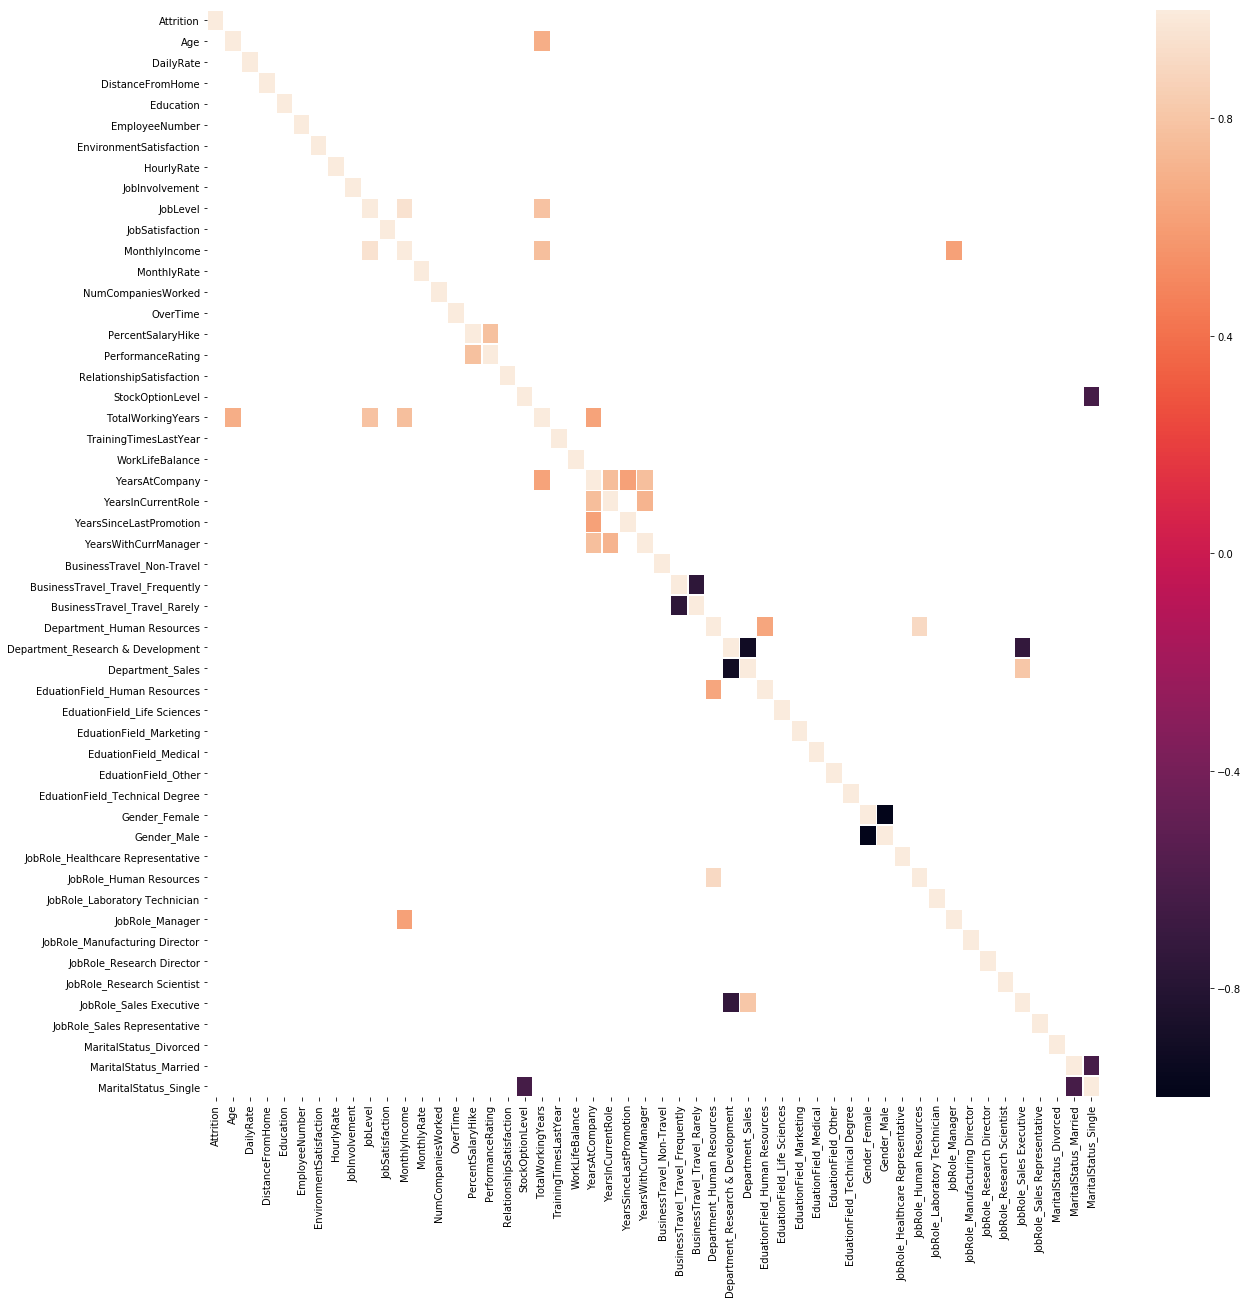

In [37]:
plt.figure(figsize = (20,20))
corr = attrition_df.corr()
sns.heatmap(corr[(corr >= 0.6) | (corr <= -0.6)], 
        xticklabels=columns_with_attrition,
        yticklabels=columns_with_attrition, linewidths=.6)

Based off looking at the correlation heatmap above, there are not any values that stand out as extremly correlated (0.8). Thus no variables will be removed.

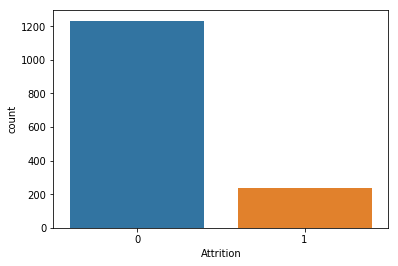

In [38]:
sns.countplot(x='Attrition',data=attrition_df)
plt.show()

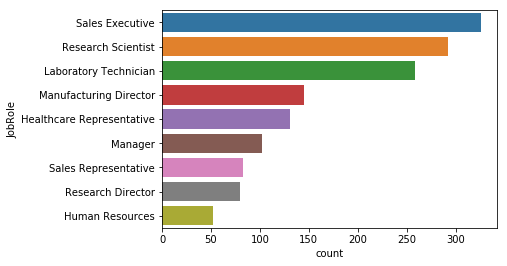

In [39]:
sns.countplot(y="JobRole", data=unchanged_attrition_df)
plt.show()

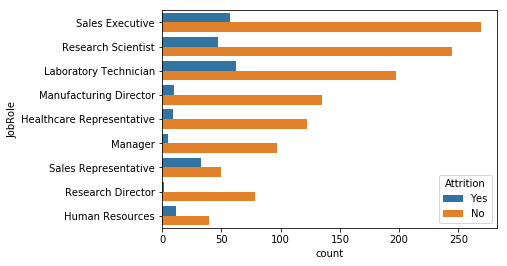

In [40]:
sns.countplot(y="JobRole", hue="Attrition", data=unchanged_attrition_df)
plt.show()

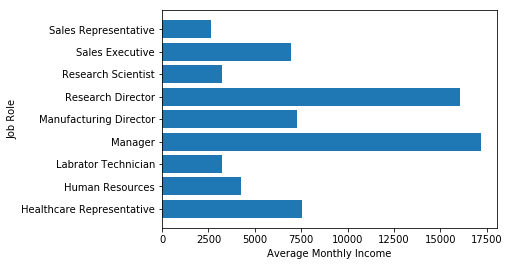

In [41]:
income = unchanged_attrition_df.groupby('JobRole').mean()[['MonthlyIncome']].values
flattened_income = []
for i in income:
    flattened_income.append(i[0])
    
roles = ['Healthcare Representative', 'Human Resources', 'Labrator Technician', 'Manager', 'Manufacturing Director', 'Research Director', 'Research Scientist' , 'Sales Executive','Sales Representative']

y_pos = np.arange(len(roles))

plt.xlabel('Average Monthly Income')
plt.ylabel('Job Role')
 
# Create horizontal bars
plt.barh(y_pos, flattened_income)
 
# Create names on the y-axis
plt.yticks(y_pos, roles)
 
# Show graphic
plt.show()

## Modeling

### Recursive Feature Elimination

In [42]:
np.set_printoptions(precision=3)

values = train.values

X = values[:,1:(len(train.columns))]
Y = values[:,0]

test_values = test.values
X_test = test_values[:,1:(len(test.columns))]
Y_test = test_values[:,0]


number_of_features_to_select = 5
# feature extraction
model = LogisticRegression()
rfe = RFE(model, number_of_features_to_select)
fit = rfe.fit(X, Y)
print(fit.support_)
print(fit.ranking_)
true_indexes = [i for i, x in enumerate(fit.support_) if x == True]
features = np.asarray(columns_without_attrition[true_indexes])
print(features)

print('Accuracy of RFE on test set: {:.5f}'.format(fit.score(X_test, Y_test)))

[False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False  True  True  True False False False
 False False False]
[39 44 37 40 47 15 43  8 25 16 46 45 28  1 36 35 22 31 30 20 18 33 24 26
 34  4 11 19 27 29 17 12 41 10 32  6  7 21 14  1  9  5  1  1  1 42 38  3
 13 23  2]
['OverTime' 'JobRole_Healthcare Representative' 'JobRole_Manager'
 'JobRole_Manufacturing Director' 'JobRole_Research Director']
Accuracy of RFE on test set: 0.82958


### Feature Importance With ExtraTreesClassifier

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
model = ExtraTreesClassifier()
fit = model.fit(X, Y)

importances = model.feature_importances_
print(importances)

idxs = np.argsort(importances)[-(number_of_features_to_select):]
features = np.asarray(columns_without_attrition[idxs])
print(list(reversed(features.tolist())))

predictions = model.predict(X_test)
print('Accuracy of extra trees classifier on test set: {:.5f}'.format(model.score(X_test, Y_test)))


[0.041 0.032 0.034 0.024 0.026 0.034 0.025 0.035 0.02  0.032 0.025 0.022
 0.032 0.053 0.031 0.013 0.03  0.017 0.024 0.022 0.025 0.028 0.036 0.025
 0.027 0.008 0.021 0.009 0.006 0.009 0.011 0.003 0.015 0.013 0.017 0.004
 0.014 0.014 0.018 0.007 0.004 0.017 0.002 0.011 0.004 0.012 0.007 0.014
 0.008 0.015 0.025]
['OverTime', 'Age', 'YearsInCurrentRole', 'JobInvolvement', 'DistanceFromHome']
Accuracy of extra trees classifier on test set: 0.84887


### Random Forrest

In [44]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X, Y)

clf.predict(X_test)

train.describe()
test.describe()
preds = clf.predict_proba(X_test)

predictions = []
attrition_count = 0
not_attrition_count = 0
for pred in preds:
    if pred[0] >= pred[1]:
        not_attrition_count = not_attrition_count + 1
        predictions.append('No Attrition') 
    else:
        attrition_count = attrition_count + 1
        predictions.append('Attrition')
    
print("Attrition count: ")
print(attrition_count)
print("Not Attrition count: ")
print(not_attrition_count)
print('Accuracy of random forrest on test set: {:.5f}'.format(clf.score(X_test, Y_test)))
print(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), columns_without_attrition), reverse=True)[:5])



Attrition count: 
6
Not Attrition count: 
305
Accuracy of random forrest on test set: 0.84244
[(0.0791, 'Age'), (0.0633, 'MonthlyIncome'), (0.0563, 'MonthlyRate'), (0.0536, 'DistanceFromHome'), (0.0513, 'DailyRate')]


### Logistic Regression

In [45]:
warnings.filterwarnings('ignore')

logreg = LogisticRegression()
logreg.fit(X, Y)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, Y_test)))


Accuracy of logistic regression classifier on test set: 0.84887


In [46]:
denom = (2.0*(1.0+np.cosh(logreg.decision_function(X))))
F_ij = np.dot((X/denom[:,None]).T,X) ## Fisher Information Matrix
Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
z_scores = logreg.coef_[0]/sigma_estimates # z-score for eaach model coefficient
p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values

print(sorted(list(zip(p_values, columns_without_attrition)))[:5])

[(1.0013992195597506e-07, 'OverTime'), (0.00015547644489411798, 'DistanceFromHome'), (0.0004239931014324791, 'YearsInCurrentRole'), (0.0013740637823916359, 'EnvironmentSatisfaction'), (0.00299851300462612, 'JobSatisfaction')]


## Interesting Trends

We will looks at trends in job roles vs some of the factors that were selected in the different models.

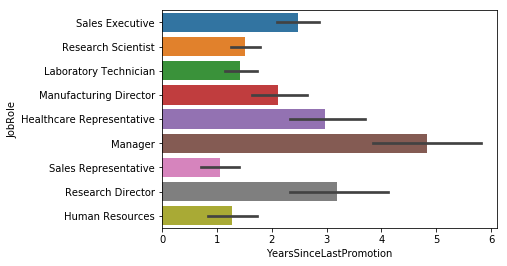

In [47]:
sns.barplot(x="YearsSinceLastPromotion", y="JobRole", data=unchanged_attrition_df)

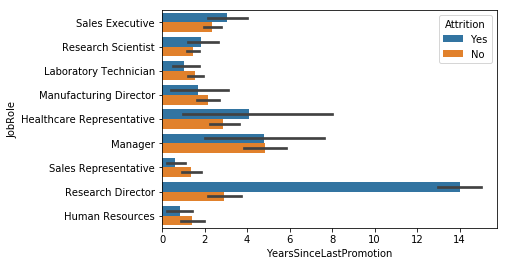

In [48]:
sns.barplot(x="YearsSinceLastPromotion", y="JobRole",hue= "Attrition", data=unchanged_attrition_df)

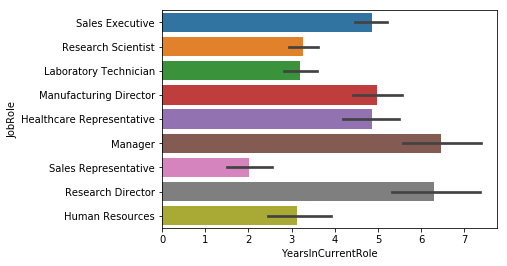

In [49]:
sns.barplot(x="YearsInCurrentRole", y="JobRole", data=unchanged_attrition_df)

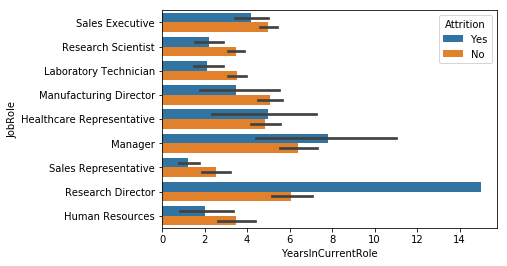

In [50]:
sns.barplot(x="YearsInCurrentRole", y="JobRole", hue= "Attrition", data=unchanged_attrition_df)

In [51]:
unchanged_attrition_df.corr()[["YearsSinceLastPromotion"]]["YearsInCurrentRole":"YearsInCurrentRole"]

,YearsSinceLastPromotion
YearsInCurrentRole,0.548056


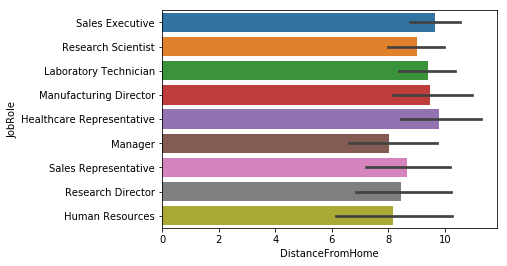

In [52]:
sns.barplot(x="DistanceFromHome", y="JobRole", data=unchanged_attrition_df)

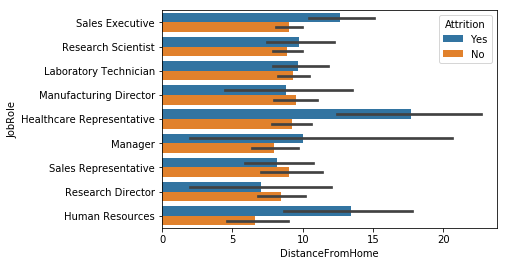

In [53]:
sns.barplot(x="DistanceFromHome", y="JobRole", hue= "Attrition", data=unchanged_attrition_df)

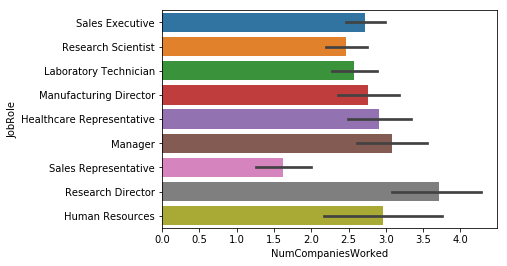

In [54]:
sns.barplot(x="NumCompaniesWorked", y="JobRole", data=unchanged_attrition_df)

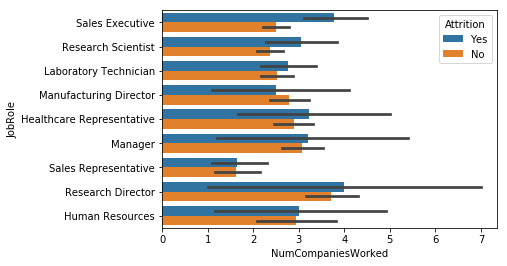

In [55]:
sns.barplot(x="NumCompaniesWorked", y="JobRole", hue="Attrition", data=unchanged_attrition_df)

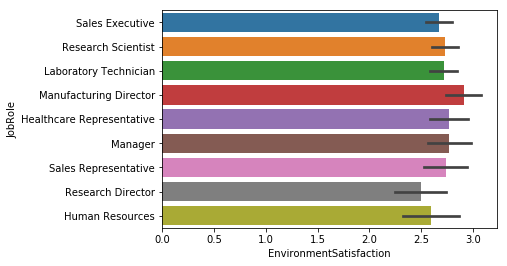

In [56]:
sns.barplot(x="EnvironmentSatisfaction", y="JobRole", data=unchanged_attrition_df)

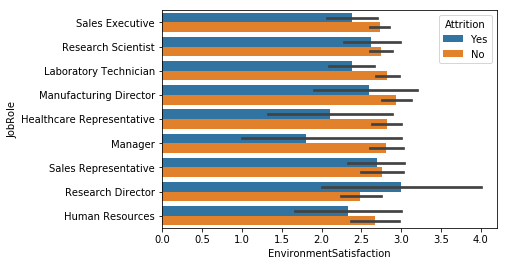

In [57]:
sns.barplot(x="EnvironmentSatisfaction", y="JobRole",hue= "Attrition", data=unchanged_attrition_df)

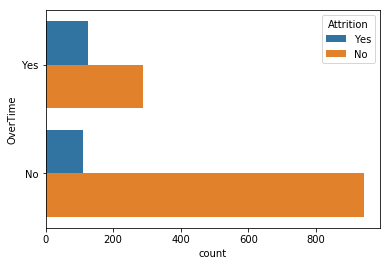

In [58]:
sns.countplot(y="OverTime", hue="Attrition", data=unchanged_attrition_df)

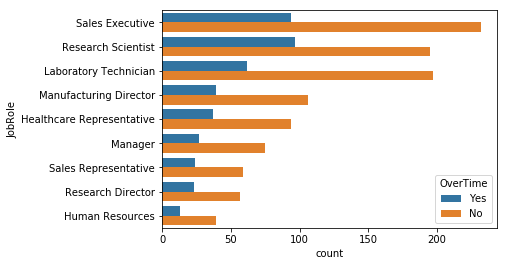

In [59]:
sns.countplot(y="JobRole", hue="OverTime", data=unchanged_attrition_df)

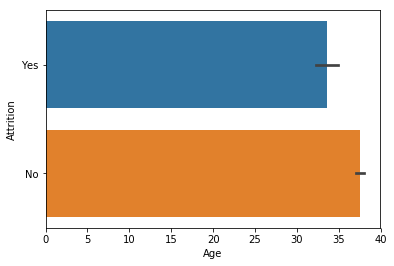

In [60]:
sns.barplot(x="Age", y="Attrition", data=unchanged_attrition_df)

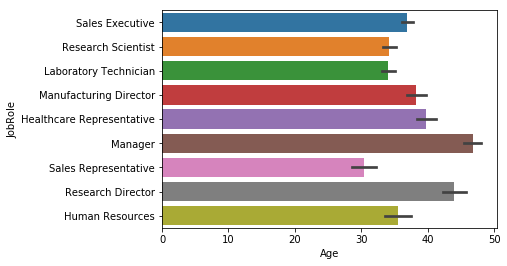

In [61]:
sns.barplot(x="Age", y="JobRole", data=unchanged_attrition_df)

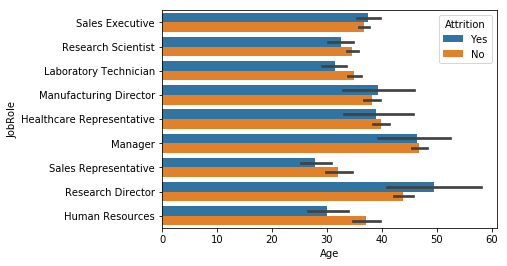

In [62]:
sns.barplot(x="Age", y="JobRole", hue="Attrition", data=unchanged_attrition_df)